In [51]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt


array([[1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1],
       [0, 1, 1, 1, 0, 0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 0, 1, 0, 0, 0, 1]])


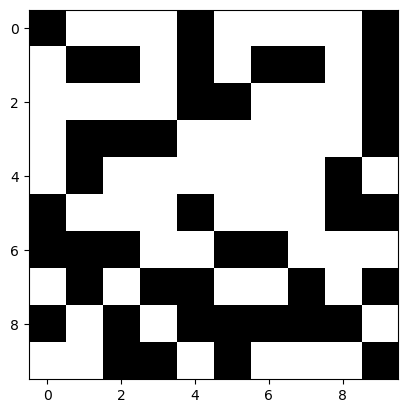

In [52]:
maze_size = (10, 10)  
maze_rand = np.random.choice([0, 1], size=maze_size)
print(repr(maze_rand))
plt.imshow(maze_rand, cmap='binary')
plt.show()

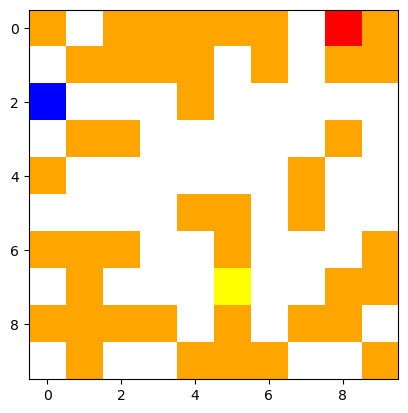

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9), (7, 5)]
(101, 4)
Q matrix: 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 

In [58]:
class Maze_env:
    def __init__(self , start, target, coins, maze):
        self.maze = maze
        self.target = target
        self.start = start
        self.coins = coins
        self.position = 0
        self.R = 0
        self.Q = 0
        self.states = []
        self.coin_collected = False
        self.terminate = False
        
    def plot_env(self):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[self.start] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.show()
        
    def plot_env_position(self, position, timestep):
        cmap = plt.cm.colors.ListedColormap(['white', 'orange', 'red', 'blue', 'yellow'])
        maze_plot = self.maze.copy()
        maze_plot[self.target] = 2
        maze_plot[position] = 3
        maze_plot[self.coins] = 4
        plt.imshow(maze_plot, cmap=cmap)
        plt.savefig(f'img/plot_{timestep:06d}.png', dpi=300)
        plt.show()
        plt.close() 
        
    def create_r_matrix(self):
        actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        num_states = self.maze.shape[0] * self.maze.shape[1]
        R = np.full((num_states, 4), np.nan)

        state_index = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
            # If the cell is not a wall
                if self.maze[i, j] == 0:
                    for index, action in enumerate(actions):
                        new_position = (i + action[0], j + action[1])
                        # If action leads to a valid state
                        if (0 <= new_position[0] < self.maze.shape[0] and
                            0 <= new_position[1] < self.maze.shape[1] and
                            self.maze[new_position] == 0):
                            # Calculate the state number for the new position
                            # Set reward to 0
                            R[state_index, index] = -5

                            # If action leads to goal state set reward to 100
                            if new_position == self.target:
                                R[state_index, index] = 1000
                            if new_position == self.coins:
                                R[state_index, index] = 200
                state_index += 1
                            
        self.R = R
        print(self.R.shape)
        return self.R
    
    def reward(self, state, action):
        state = self.states[state]
        x, y = state
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1
        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
            return -0.  # hit a wall (including edges wall?)
        elif (x, y) == self.target:
            print("Reached Target!")
            print((x,y))
            
            return 0 + int(self.coin_collected == True) # reached the target and bonus if collected coin
        elif (x, y) == self.coins and not self.coin_collected:
            print("DING DING DING")
            return 10
        else:
            return -0.001  # regular step
        
    def transition(self, state, action):
        state_new = self.states[state]
        x, y = state_new
        if action == 0:  # up
            x -= 1
        elif action == 1:  # down
            x += 1
        elif action == 2:  # left
            y -= 1
        elif action == 3:  # right
            y += 1

        if x < 0 or x >= len(self.maze) or y < 0 or y >= len(self.maze[0]) or self.maze[x][y] == 1:
#             self.terminate = True
            return self.states.index(state_new)  # hit a wall, stay in the same state
        else:
            if (x, y) == self.coins and not self.coin_collected:
                self.coin_collected = True
                return 100 #specific index for coin
            else:
                if (x, y) == self.target:
                    self.terminate = True
                return self.states.index((x,y))  # move to the new state
        
    def done(self):
        return self.terminate
    
    def create_q_matrix(self):
        coord_to_index = []
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                coord_to_index.append((i,j))
        coord_to_index.append(self.coins)
        print(coord_to_index)
                
        num_states = self.maze.shape[0] * self.maze.shape[1] + 1
        num_actions = 4
        self.Q = np.zeros((num_states, num_actions))
        print(self.Q.shape)
        self.states = coord_to_index
        return self.Q, coord_to_index

maze = np.array([
    [1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
 [0, 1, 1, 1, 1, 0, 1, 0, 1, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 1, 0, 0, 0, 1],
 [0, 1, 0, 0, 0, 0, 0, 0, 1, 1],
 [1, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [0, 1, 0, 0, 1, 1, 1, 0, 0, 1]
                ])
# env = Maze_env((2,0),(0,8),(6,6), maze) 
env = Maze_env((2,0),(0,8),(7,5), maze) 
env.plot_env()
# R = env.create_r_matrix()
# print('R matrix: \n\n{}'.format(R))
Q, coord_to_index = env.create_q_matrix()
print('Q matrix: \n\n{}'.format(Q))




In [59]:
class Q_learning:
    
    def __init__(self, alpha, gamma, epsilon, episodes, steps, env, states):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.temperature = 100.0
        self.states = states

#         self.R = env.R
#         self.R_mod = self.R.copy()
        self.Q = env.Q
        self.episodes = episodes
        self.steps = steps
        self.start = env.start
        self.target = self.states.index(env.target)
        self.coins = env.coins
        self.env = env
        self.episodes_rewards = []
        self.max_list_size = 10
        self.list_rewards = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        self.threshold = 2
        self.window_size = 4
        self.current_average = 0
        
        print("Initial Q matrix is '{}'".format(self.Q))

    def plot_rewards(self):
        plt.plot(self.episodes_rewards)
        plt.show()
        
    def show_Q_spec(self,coord):
        print(q_learning.Q[self.states.index(coord)])
        
    def greedy_policy(self, state):
#                 available_actions = np.where(~np.isnan(self.R_mod[s]))[0]
#                 q_values = [self.Q[s,a] for a in available_actions]
#                 best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]
        
        available_actions = np.array([0,1,2,3])
        q_values = [self.Q[state,a] for a in available_actions]
        best_actions = available_actions[np.where(q_values == np.max(q_values))[0]]

        if np.random.uniform() < self.epsilon:
            a = np.random.choice(4)
#                     a = np.random.choice(available_actions)
        else:
#                     a = np.argmax(self.Q[s,:])
            a = np.random.choice(best_actions)
        return a
    
    def softmax_policy(self, state, temperature = 1.0):
        available_actions = np.array([0,1,2,3])
        q_values = np.array([self.Q[state,a] for a in available_actions])
        max_q_value = np.max(q_values)
        exp_values = np.exp((q_values - max_q_value) / temperature)
        action_probs = exp_values / np.sum(exp_values)

        # Sample an action based on the probabilities
        selected_action = np.random.choice(len(action_probs), p=action_probs)
        return selected_action
        
    def train(self):
        print(self.states)
        print("Starting taget is '{}'".format(self.target))
        for episode in range(self.episodes):
            s = self.states.index(self.start)
            print("Starting state is '{}'".format(s))
            episode_reward = 0
            env.coin_collected = False
            env.terminate = False
#             self.R_mod = self.R
            for timestep in range(self.steps):

                # Epsilon-greedy action choice
#                 a = self.greedy_policy(s)
                a = self.softmax_policy(s, self.temperature)

                # Environment updating
                r = env.reward(s, a)
#                 r = self.R_mod[s,a]
                episode_reward += r
                new_s = env.transition(s, a)
                # Doubts coordinates to Q system?
                # Q value updating
#                 print(new_s)
                self.Q[s,a] = self.Q[s,a] + self.alpha * ( r + self.gamma * np.max(self.Q[new_s,:]) - self.Q[s,a])

                if env.done():
                    break
                s = new_s
            
            self.episodes_rewards.append(episode_reward)
            
            self.list_rewards.append(episode_reward)
            if len(self.list_rewards) > self.max_list_size:
                self.list_rewards.pop(0)
            window = self.list_rewards[-self.window_size:]
            window_average = sum(window) / self.window_size
#             if abs(self.current_average - window_average) < self.threshold:
#                 print(f"Average exceeded threshold at episode {episode}. STOPPING!")
#                 break 
            self.current_average = window_average

            if episode % 2 == 0:
                print('Episode {} finished. Episode Reward {}. Timesteps {}. Average {}'.format(episode,episode_reward,timestep, window_average))
            self.epsilon = max(self.epsilon*0.999,0.01)
            self.temperature = max(self.temperature*0.998,0.01)

            print(self.temperature)
            
    def create_video(self):
        image_folder = 'img'  # Directory containing your saved plot images
        video_name = 'video_agent.mp4'

        images = [img for img in os.listdir(image_folder) if img.endswith((".jpg", ".jpeg", ".png"))]
        frame = cv2.imread(os.path.join(image_folder, images[0]))
        height, width, layers = frame.shape

        video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, (width, height))

        for image in images:
            video.write(cv2.imread(os.path.join(image_folder, image)))

        cv2.destroyAllWindows()
        video.release()
        
    
    def test(self, limit):

        s = self.states.index(self.start)
        print("Starting state is '{}'".format(s))
        episode_reward = 0
        env.coin_collected = False
        for timestep in range(limit):
            self.env.plot_env_position(self.states[s], timestep)
            print(self.Q[s])
            a = np.argmax(self.Q[s])
            print(a)

            # Environment updating
            r = env.reward(s, a)
            print(r)
            episode_reward += r
            temp_new_s = env.transition(s, a)
#             new_s = self.states.index(temp_new_s)

            if temp_new_s == self.target:
                self.env.plot_env_position(self.states[temp_new_s], timestep)
                break
            s = temp_new_s
        print('Episode Reward {}.Q matrix values:\n{}'.format(episode_reward,self.Q.round(1)))
        self.create_video()



            

In [ ]:
q_learning = Q_learning(1, 0.999, 1, 5000, 2000, env, coord_to_index)
q_learning.train()

Initial Q matrix is '[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0.

90.47468180040356
Starting state is '20'
DING DING DING
Episode 50 finished. Episode Reward 8.77000000000059. Timesteps 1999. Average 9.506000000000473
90.29373243680276
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
90.11314497192915
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
Episode 52 finished. Episode Reward 10.292000000000254. Timesteps 1195. Average 9.49150000000046
89.93291868198529
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
89.75305284462131
Starting state is '20'
DING DING DING
Episode 54 finished. Episode Reward 8.776000000000622. Timesteps 1999. Average 9.91450000000037
89.57354673893207
Starting state is '20'
DING DING DING
89.3943996454542
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
Episode 56 finished. Episode Reward 10.352000000000011. Timesteps 1126. Average 9.585250000000354
89.21561084616329
Starting state is '20'
DING DING DING
Reached Target!
(0, 8)
89.03717962447097
Starting state is '20'
DING DING 

Episode 126 finished. Episode Reward 8.717000000000686. Timesteps 1999. Average 8.739750000000582
77.54945383201259
Starting state is '20'
DING DING DING
77.39435492434856
Starting state is '20'
DING DING DING
Episode 128 finished. Episode Reward 8.81000000000052. Timesteps 1999. Average 8.77425000000059
77.23956621449986
Starting state is '20'
DING DING DING
77.08508708207086
Starting state is '20'
DING DING DING
Episode 130 finished. Episode Reward 8.749000000000636. Timesteps 1999. Average 8.782750000000597
76.93091690790672
Starting state is '20'
DING DING DING
76.77705507409091
Starting state is '20'
DING DING DING
Episode 132 finished. Episode Reward 8.74700000000067. Timesteps 1999. Average 8.771750000000642
76.62350096394273
Starting state is '20'
DING DING DING
76.47025396201485
Starting state is '20'
DING DING DING
Episode 134 finished. Episode Reward 8.773000000000577. Timesteps 1999. Average 8.785750000000585
76.31731345409082
Starting state is '20'
DING DING DING
76.164678

DING DING DING
66.20510904222178
Starting state is '20'
DING DING DING
Episode 206 finished. Episode Reward 8.822000000000626. Timesteps 1999. Average 8.796000000000564
66.07269882413733
Starting state is '20'
DING DING DING
65.94055342648906
Starting state is '20'
DING DING DING
Episode 208 finished. Episode Reward 8.804000000000356. Timesteps 1999. Average 8.831000000000486
65.80867231963609
Starting state is '20'
DING DING DING
65.67705497499682
Starting state is '20'
DING DING DING
Episode 210 finished. Episode Reward 8.78900000000056. Timesteps 1999. Average 8.81000000000045
65.54570086504683
Starting state is '20'
DING DING DING
65.41460946331674
Starting state is '20'
DING DING DING
Episode 212 finished. Episode Reward 8.797000000000583. Timesteps 1999. Average 8.79600000000051
65.2837802443901
Starting state is '20'
DING DING DING
65.15321268390132
Starting state is '20'
DING DING DING
Episode 214 finished. Episode Reward 8.764000000000626. Timesteps 1999. Average 8.75475000000

Episode 284 finished. Episode Reward 8.749000000000574. Timesteps 1999. Average 8.777500000000556
56.52027508520141
Starting state is '20'
DING DING DING
56.40723453503101
Starting state is '20'
DING DING DING
Episode 286 finished. Episode Reward 8.726000000000647. Timesteps 1999. Average 8.738000000000634
56.29442006596095
Starting state is '20'
DING DING DING
56.18183122582903
Starting state is '20'
DING DING DING
Episode 288 finished. Episode Reward 8.75300000000066. Timesteps 1999. Average 8.742500000000652
56.06946756337737
Starting state is '20'
DING DING DING
55.957328628250615
Starting state is '20'
DING DING DING
Episode 290 finished. Episode Reward 8.817000000000553. Timesteps 1999. Average 8.78800000000062
55.845413970994116
Starting state is '20'
DING DING DING
55.733723143052124
Starting state is '20'
DING DING DING
Episode 292 finished. Episode Reward 8.786000000000422. Timesteps 1999. Average 8.785250000000524
55.62225569676602
Starting state is '20'
DING DING DING
55.51

Episode 362 finished. Episode Reward 8.744000000000664. Timesteps 1999. Average 8.786250000000539
48.348887703370536
Starting state is '20'
DING DING DING
48.2521899279638
Starting state is '20'
DING DING DING
Episode 364 finished. Episode Reward 8.742000000000608. Timesteps 1999. Average 8.761000000000513
48.15568554810787
Starting state is '20'
DING DING DING
48.059374177011655
Starting state is '20'
DING DING DING
Episode 366 finished. Episode Reward 8.728000000000442. Timesteps 1999. Average 8.76625000000045
47.96325542865763
Starting state is '20'
DING DING DING
47.867328917800315
Starting state is '20'
DING DING DING
Episode 368 finished. Episode Reward 8.729000000000685. Timesteps 1999. Average 8.76050000000053
47.771594259964715
Starting state is '20'
DING DING DING
47.67605107144479
Starting state is '20'
DING DING DING
Episode 370 finished. Episode Reward 8.753000000000517. Timesteps 1999. Average 8.73000000000056
47.5806989693019
Starting state is '20'
DING DING DING
47.4855

In [ ]:
q_learning.plot_rewards()

In [ ]:
q_learning.test(50)

In [33]:
q_learning.show_Q_spec((5,6))
q_learning.show_Q_spec((3,5))
q_learning.show_Q_spec((4,5))

[0.65701163 0.67080684 0.55217423 0.57211771]
[0.62820745 0.65535461 0.65535461 0.65535461]
[0.65369926 0.54229192 0.65369926 0.65418256]


In [ ]:
7
